In [1]:
import sys; sys.path.append("../") # For relative imports

from utils.experiment_utils import *

%load_ext autoreload
%autoreload 2

This notebook creates the main line plots of various metrics for each datset and score function combination.

**Note**: Before running this notebook, run `sh run_experiment.sh`.

In [2]:
save_folder = '../.cache/paper/varying_n'
dataset_list = ['imagenet', 'cifar-100', 'places365', 'inaturalist']
cal_sampling_list = ['random']
n_list = [10, 20, 30, 40, 50, 75, 100, 150]
score_function_list = ['softmax', 'APS', 'RAPS']
method_list = ['standard', 'classwise', 'cluster_random', 
               'exact_coverage_standard', 'exact_coverage_classwise', 'exact_coverage_cluster']
metric_list = ['class_cov_gap', 'avg_set_size', 'very_undercovered']

expected_num_seeds = 10

In [3]:
# Set plot settings
sns.set_style(style='white', rc={'axes.spines.right': False, 'axes.spines.top': False})
sns.set_palette('pastel')
sns.set_context('paper') # 'paper', 'talk', 'poster'

In [4]:
# Helper function to check which results are missing. If nothing prints, all results exist! 
def check_for_missing_results(save_folder, dataset_list, cal_sampling_list, 
                              n_list, score_function_list, method_list,
                              expected_num_seeds=10):
    '''
    Check if results exist for all combinations of settings
    '''
    for dataset in dataset_list:
        for cal_sampling in cal_sampling_list:
            for n_totalcal in n_list: 
                for score_function in score_function_list:
                    for seed in range(expected_num_seeds):
                        pth = os.path.join(save_folder,
                                           f'{dataset}/{cal_sampling}_calset/n_totalcal={n_totalcal}/score={score_function}/seed={seed}_allresults.pkl')
                    
                        try:
                            with open(pth, 'rb') as f:
                                results = pickle.load(f)
                                
                            for method in method_list:
                                if method not in results.keys():
                                    print(f'{method} is missing in {pth}')
                        except:
                            print(f'Missing file {pth}')
                                
check_for_missing_results(save_folder, dataset_list, cal_sampling_list, 
                              n_list, score_function_list, method_list,
                              expected_num_seeds=10)

If any results are missing, you can rerun individual experiments using a command like 
`python run_experiment.py imagenet 100 -score_functions APS RAPS -methods standard classwise cluster_random exact_coverage_standard exact_coverage_classwise exact_coverage_cluster -seeds 0 1 2 3 4 5 6 7 8 9 &`

# Single plots
Useful for previewing all results

In [5]:
def make_varying_n_plot(dataset, score_function, 
                        n_list = [10, 20, 30, 40, 50, 75, 100], 
                        save_folder='../.cache/paper/varying_n',
                        metric_list = ['class_cov_gap', 'avg_set_size'],
                        cal_sampling = 'random',
                        metric_to_name = {'class_cov_gap': 'CovGap', 'avg_set_size': 'AvgSize', 'very_undercovered': 'Fraction very undercovered'},
                        method_list = ['standard', 'classwise', 'classwise_default_standard', 'cluster_balanced'],
                        dataset_to_name = {'imagenet': 'ImageNet', 'cifar-100': 'CIFAR-100', 
                                           'places365': 'Places365', 'inaturalist': 'iNaturalist'}): 

    # 1) Compute aggregated_results dict
    aggregated_results = initialize_dict(metric_list, method_list)

    for n_totalcal in n_list:

        curr_folder = f'{save_folder}/{dataset}/{cal_sampling}_calset/n_totalcal={n_totalcal}/score={score_function}'

#         print(curr_folder)
        df = average_results_across_seeds(curr_folder, print_results=False, 
                                          display_table=False, methods=method_list, max_seeds=10) # Only use at most 10 seeds

#         display(df)
        for metric in metric_list:

            for method in method_list:

                for suffix in ['mean', 'se']: # Extract mean and SE

                    aggregated_results[f'{metric}_{suffix}'][method].append(df[f'{metric}_{suffix}'][df['method']==method].values[0])
    
    # 2) Make plot 
    for metric in metric_list:

            for method in method_list:
                x = n_list
                y = np.array(aggregated_results[f'{metric}_mean'][method])
                se = np.array(aggregated_results[f'{metric}_se'][method])
                plt.plot(x, y, '-o', label=method, alpha=1)
                # Add 95% error bars
                plt.fill_between(x, y-1.96*se, y+1.96*se, alpha=0.4)

            plt.xlabel('Average number of examples per class')
            plt.ylabel(metric_to_name[metric])
            plt.title(f'{dataset_to_name[dataset]}, {score_function} ({cal_sampling} calibration set)')
            plt.legend()
            if metric == 'class_cov_gap':
                plt.ylim(1,9)
            if metric == 'avg_set_size':
                plt.ylim(0,20)
                
            plt.xscale('squareroot')
            plt.xlim(left=8)
            
            plt.xticks(n_list)
            plt.show()

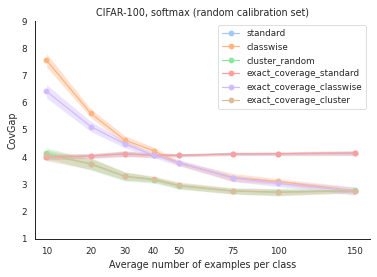

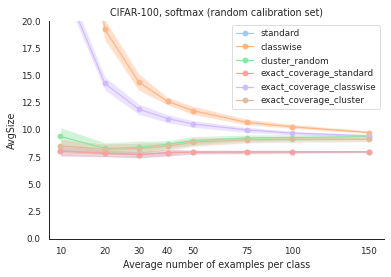

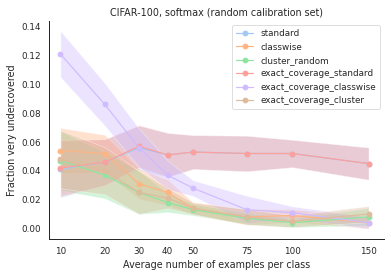

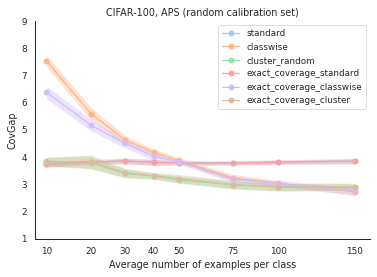

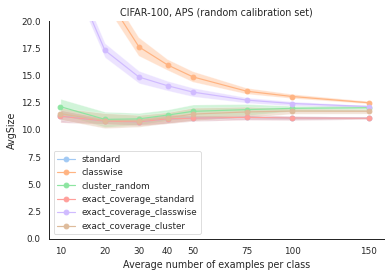

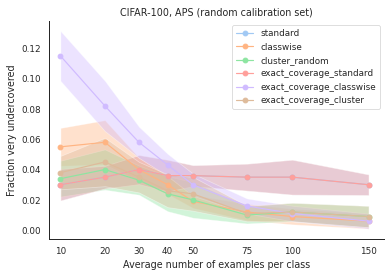

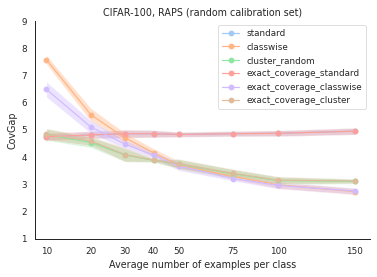

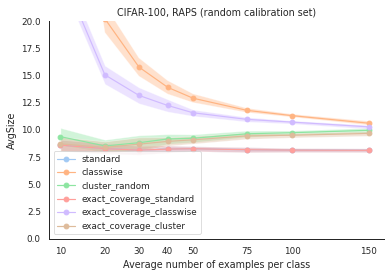

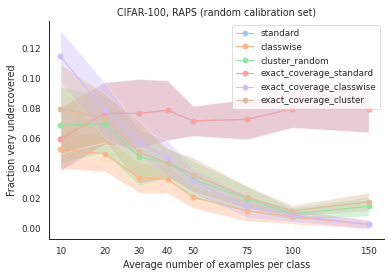

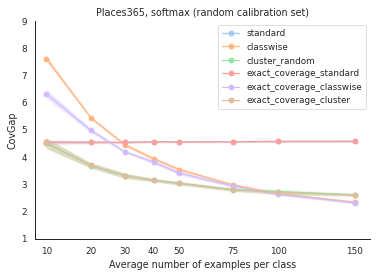

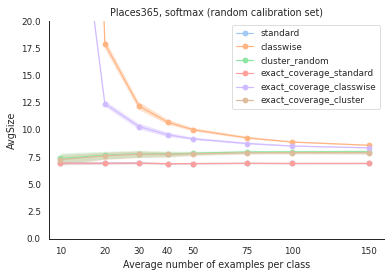

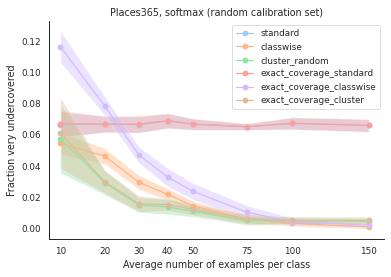

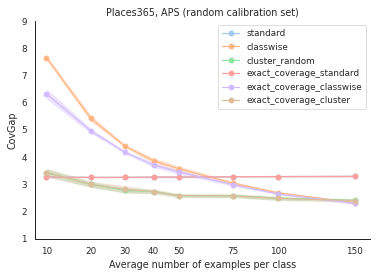

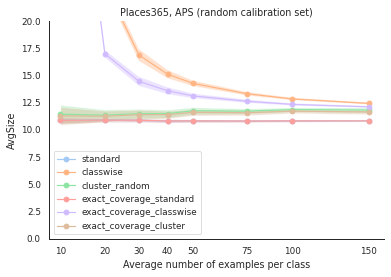

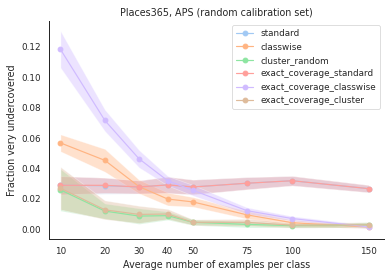

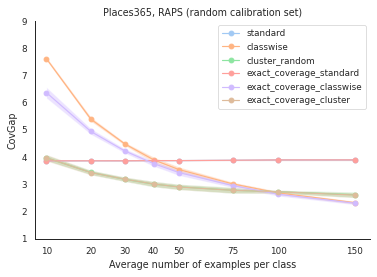

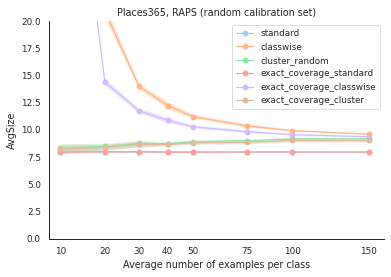

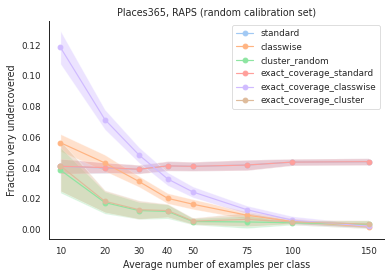

In [6]:
for cal_sampling in cal_sampling_list:
    for dataset in ['cifar-100', 'places365']:
        for score_function in score_function_list:
            make_varying_n_plot(dataset, score_function, n_list=n_list, cal_sampling=cal_sampling,
                                metric_list=metric_list, method_list=method_list)

# for cal_sampling in cal_sampling_list:
#     for dataset in dataset_list:
#         for score_function in score_function_list:
#             make_varying_n_plot(dataset, score_function, n_list=n_list, cal_sampling=cal_sampling,
#                                 metric_list=metric_list, method_list=method_list)

# Combined plots

Here, we organize some plots together for the purposes of the paper

In [7]:
method_to_name = {'standard': 'Standard', 
                  'classwise': 'Classwise',
                  'cluster_random': 'Clustered',
                  'exact_coverage_standard': 'Randomized Standard',
                  'exact_coverage_classwise': 'Randomized Classwise',
                  'exact_coverage_cluster': 'Randomized Clustered'}

metric_to_name = {'class_cov_gap': 'CovGap', 'avg_set_size': 'AvgSize', 'very_undercovered': 'FracUnderCov'}     

dataset_to_name = {'imagenet': 'ImageNet', 'cifar-100': 'CIFAR-100', 
                       'places365': 'Places365', 'inaturalist': 'iNaturalist'}

In [8]:
def make_line_plot(aggregated_results, ax, 
                        n_list = [10, 20, 30, 40, 50, 75, 100, 150],
                        metric_to_name = {'class_cov_gap': 'CovGap', 'avg_set_size': 'AvgSize', 'very_undercovered': 'FracUnderCov'},
                        method_list = ['standard', 'classwise', 'cluster_random'],
                        method_to_name = {'standard': 'Standard', 
                                          'classwise': 'Classwise',
                                          'cluster_random': 'Clustered',
                                          'exact_coverage_standard': 'Randomized Standard',
                                          'exact_coverage_classwise': 'Randomized Classwise',
                                          'exact_coverage_cluster': 'Randomized Clustered'},
                        dataset_to_name = {'imagenet': 'ImageNet', 'cifar-100': 'CIFAR-100', 
                       'places365': 'Places365', 'inaturalist': 'iNaturalist'},
                        specify_color={}):

    print(f'{dataset_to_name[dataset]}, {score_function} ({cal_sampling} calibration set)')

    for method in method_list:
        x = n_list
        y = np.array(aggregated_results[f'{metric}_mean'][method])
        se = np.array(aggregated_results[f'{metric}_se'][method])
        if method in specify_color:
            color = specify_color[method]
            ax.plot(x, y, '-o', label=method_to_name[method], alpha=1, color=color)         
            ax.fill_between(x, y-1.96*se, y+1.96*se, alpha=0.4, color=color) # Add 95% error bars
        else:
            ax.plot(x, y, '-o', label=method_to_name[method], alpha=1)
            ax.fill_between(x, y-1.96*se, y+1.96*se, alpha=0.4) # Add 95% error bars

        ax.set_xlabel('$n_{avg}$', fontsize=FONT_SIZE)


    ax.set_xscale('squareroot')
    ax.set_xlim(left=8)
    
    if metric == 'class_cov_gap':
        ax.set_ylim(1,9)
#     if metric == 'avg_set_size':
#         ax.set_ylim(0,40)

    ax.set_xticks(n_list)
    ax.tick_params(labelsize=FONT_SIZE-2) # Adjust tick label font size


### ImageNet softmax + APS plots

ImageNet, APS (random calibration set)
ImageNet, RAPS (random calibration set)
Saved plot to /home/tding/code/class-conditional-conformal/figs/imagenet_randomcalset_combined.pdf


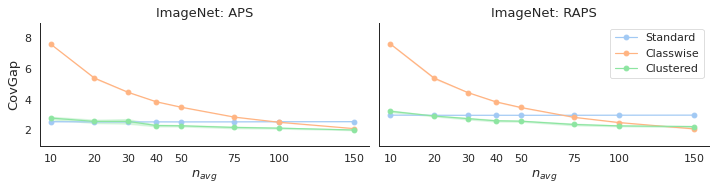

In [9]:
FONT_SIZE = 13

metric = 'class_cov_gap' 
fig_folder = '/home/tding/code/class-conditional-conformal/figs/'

dataset = 'imagenet'
cal_sampling = 'random'

# Side-by-side plots
ncols = 2
fig, axs = plt.subplots(1,ncols, 
                        gridspec_kw={'wspace':0.03},
                        figsize=(12, 2.25)) 

# for i, score_function in enumerate(['softmax', 'APS']):
score_function_list = ['APS', 'RAPS']
for i, score_function in enumerate(score_function_list):
    # Get data
    aggregated_results = get_metric_df(dataset, cal_sampling, metric, score_function, 
                                       method_list=method_list, print_folder=False)

    # Plot
    make_line_plot(aggregated_results, axs[i])
    
#     save_to = os.path.join(fig_folder, f'{dataset}_{cal_sampling}calset_{score_function}.pdf')
   
# Remove yticks for all but left-most axis
for i in range(1, ncols):
    axs[i].set_yticks([])
 
axs[0].set_ylabel(metric_to_name[metric], fontsize=FONT_SIZE)
axs[0].set_title(f'ImageNet: {score_function_list[0]}', fontsize=FONT_SIZE)
axs[1].set_title(f'ImageNet: {score_function_list[1]}', fontsize=FONT_SIZE)
axs[-1].legend(fontsize=FONT_SIZE-2) # Only show legend on right-most plot


    
save_to = os.path.join(fig_folder, f'{dataset}_{cal_sampling}calset_combined.pdf')
print(f'Saved plot to {save_to}')
plt.savefig(save_to, bbox_inches='tight')

plt.show()

### softmax and APS plots for remaining datasets

CIFAR-100, APS (random calibration set)
Places365, APS (random calibration set)
iNaturalist, APS (random calibration set)
Saved figure to /home/tding/code/class-conditional-conformal/figs/last3datasets_randomcalset_APS.pdf


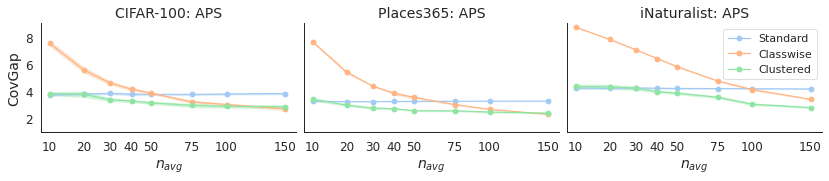

CIFAR-100, RAPS (random calibration set)
Places365, RAPS (random calibration set)
iNaturalist, RAPS (random calibration set)
Saved figure to /home/tding/code/class-conditional-conformal/figs/last3datasets_randomcalset_RAPS.pdf


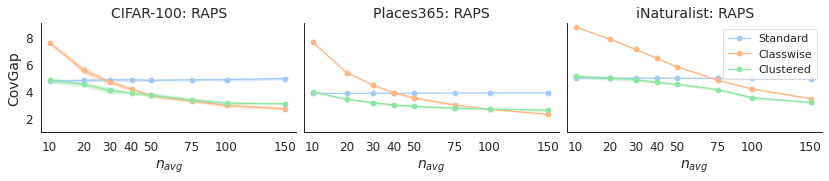

In [10]:
FONT_SIZE = 14

metric = 'class_cov_gap' 
fig_folder = '/home/tding/code/class-conditional-conformal/figs/'

cal_sampling = 'random'
dataset_list = ['cifar-100', 'places365', 'inaturalist']

# ==== PLOT 1a and 1b ==== 
score_function_list = ['APS', 'RAPS']
for score_function in score_function_list:
    
    ncols = len(dataset_list)
    fig, axs = plt.subplots(1,ncols, 
                        gridspec_kw={'wspace':0.03},
                        figsize=(14, 2)) 
    
    for i, dataset in enumerate(dataset_list):

        aggregated_results = get_metric_df(dataset, cal_sampling, metric, score_function, print_folder=False)

        # Plot
        make_line_plot(aggregated_results, axs[i])
        axs[i].set_title(f'{dataset_to_name[dataset]}: {score_function}', fontsize=FONT_SIZE)
    
    # Remove yticks for all but left-most axis
    for i in range(1, ncols):
        axs[i].set_yticks([])

    axs[0].set_ylabel(metric_to_name[metric], fontsize=FONT_SIZE)
    axs[-1].legend(fontsize=FONT_SIZE-3) # Only show legend on right-most plot
    
    save_to = os.path.join(fig_folder, f'last3datasets_{cal_sampling}calset_{score_function}.pdf')
    plt.savefig(save_to, bbox_inches='tight')
    print(f'Saved figure to {save_to}')
    
    plt.show()

## RAPS CovGap plots

ImageNet, RAPS (random calibration set)
CIFAR-100, RAPS (random calibration set)
Places365, RAPS (random calibration set)
iNaturalist, RAPS (random calibration set)
Saved figure to /home/tding/code/class-conditional-conformal/figs/RAPS_alldatasets_randomcalset_class_cov_gap_height6.pdf


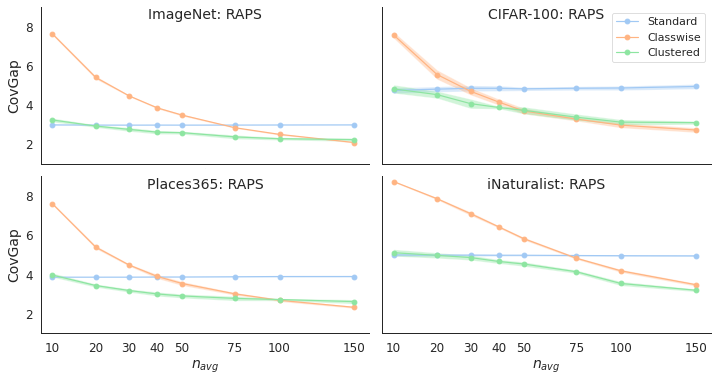

In [11]:
FONT_SIZE = 14
fig_height = 6

metric_list = ['class_cov_gap']
fig_folder = '/home/tding/code/class-conditional-conformal/figs/'

cal_sampling = 'random'
dataset_list = ['imagenet', 'cifar-100', 'places365', 'inaturalist']
score_function = 'RAPS'

nrows = 2
ncols = 2

for metric in metric_list:
    
    fig, axs = plt.subplots(nrows,ncols, 
                gridspec_kw={'wspace':0.04, # Horizontal space between subplots
                             'hspace': 0.08}, # Veritcal space between subplots
                figsize=(12, fig_height)) # Prev: (12,9)

    for i, dataset in enumerate(dataset_list):    

            r = int(np.floor(i/ncols))
            c = i - r*ncols
            ax = axs[r][c]

            aggregated_results = get_metric_df(dataset, cal_sampling, metric, 
                                               score_function, print_folder=False)

            # Plot
            make_line_plot(aggregated_results, ax)
            ax.set_title(f'{dataset_to_name[dataset]}: {score_function}', 
                         fontsize=FONT_SIZE,
                         pad=-(FONT_SIZE)+2) # Shift plot title down


    #         Remove y-ticks except for bottom plots
            if r < nrows - 1:
                ax.set_xticks([])
                ax.set_xlabel('.', fontsize=1) # hacky fix

            # Remove y-ticks and label except for left-most plots
            if c > 0:
                ax.set_yticks([])


            # Set y-label
            if c == 0:
                ax.set_ylabel(metric_to_name[metric], fontsize=FONT_SIZE)
                
#             AvgSetSize plot adjustments  
#             ax.set_yscale('squareroot') # Use square-root y-axis


#             axs[0].set_ylabel(metric_to_name[metric], fontsize=FONT_SIZE)
    axs[0, ncols-1].legend(fontsize=FONT_SIZE-3) # Only show legend on right-most plot
    
    save_to = os.path.join(fig_folder, f'RAPS_alldatasets_{cal_sampling}calset_{metric}_height{fig_height}.pdf')
    plt.savefig(save_to, bbox_inches='tight')
    print(f'Saved figure to {save_to}')

    plt.show()

## softmax + APS for all datasets (4x2 grid)

ImageNet, softmax (random calibration set)
ImageNet, APS (random calibration set)
CIFAR-100, softmax (random calibration set)
CIFAR-100, APS (random calibration set)
Places365, softmax (random calibration set)
Places365, APS (random calibration set)
iNaturalist, softmax (random calibration set)
iNaturalist, APS (random calibration set)
Saved figure to /home/tding/code/class-conditional-conformal/figs/alldatasets_randomcalset_class_cov_gap_height12.pdf


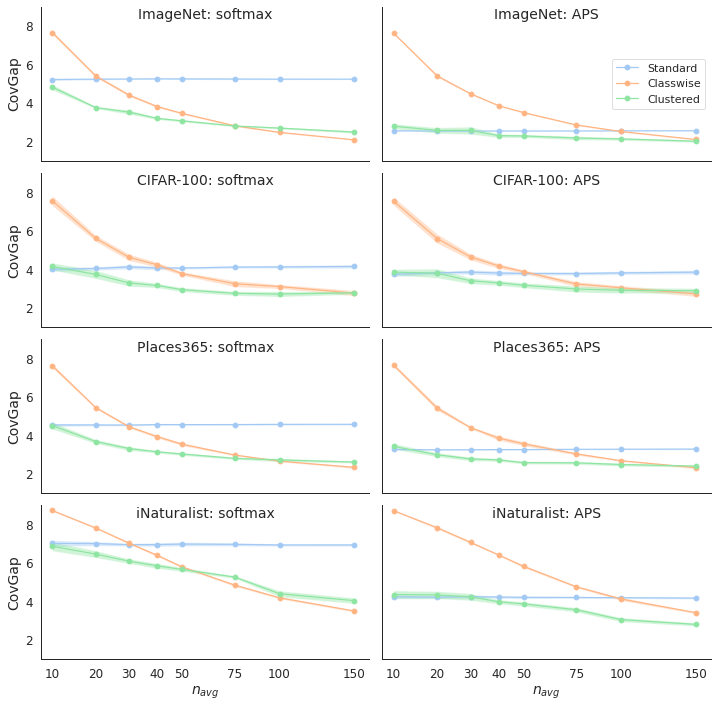

In [12]:
FONT_SIZE = 14
fig_height = 12

# metric_list = ['class_cov_gap', 'avg_set_size', 'very_undercovered']
metric_list = ['class_cov_gap']
fig_folder = '/home/tding/code/class-conditional-conformal/figs/'

cal_sampling = 'random'
dataset_list = ['imagenet', 'cifar-100', 'places365', 'inaturalist']
score_function_list = ['softmax','APS']
method_list = ['standard', 'classwise', 'cluster_random']

nrows = len(dataset_list)
ncols = len(score_function_list)

for metric in metric_list:
    
    fig, axs = plt.subplots(nrows,ncols, 
                gridspec_kw={'wspace':0.04, # Horizontal space between subplots
                             'hspace': 0.08}, # Veritcal space between subplots
                figsize=(12, fig_height)) # Prev: (12,9)

    for i, dataset in enumerate(dataset_list):    

        for j, score_function in enumerate(score_function_list):

            ax = axs[i][j]

            aggregated_results = get_metric_df(dataset, cal_sampling, metric, score_function, 
                                               method_list=method_list, print_folder=False)

            # Plot
            make_line_plot(aggregated_results, ax, method_list=method_list)
            ax.set_title(f'{dataset_to_name[dataset]}: {score_function}', 
                         fontsize=FONT_SIZE,
                         pad=-(FONT_SIZE)+2) # Shift plot title down


            # Remove y-ticks except for bottom plots
            if i < nrows - 1:
                ax.set_xticks([])
                ax.set_xlabel('.', fontsize=1) # hacky fix

            # Remove y-ticks and label except for left-most plots
            if j > 0:
                ax.set_yticks([])


            # Set y-label
            if j == 0:
                ax.set_ylabel(metric_to_name[metric], fontsize=FONT_SIZE)

    axs[0, ncols-1].legend(fontsize=FONT_SIZE-3, loc='center right') # Only show legend on right-most plot
    
    

    save_to = os.path.join(fig_folder, f'alldatasets_{cal_sampling}calset_{metric}_height{fig_height}.pdf')
    plt.savefig(save_to, bbox_inches='tight')
    print(f'Saved figure to {save_to}')

    plt.show()

## 4 x 3 grids of AvgSetSize and FracUnderCov for all scores

ImageNet, softmax (random calibration set)
ImageNet, APS (random calibration set)
ImageNet, RAPS (random calibration set)
CIFAR-100, softmax (random calibration set)
CIFAR-100, APS (random calibration set)
CIFAR-100, RAPS (random calibration set)
Places365, softmax (random calibration set)
Places365, APS (random calibration set)
Places365, RAPS (random calibration set)
iNaturalist, softmax (random calibration set)
iNaturalist, APS (random calibration set)
iNaturalist, RAPS (random calibration set)
Saved figure to /home/tding/code/class-conditional-conformal/figs/alldatasets_randomcalset_class_cov_gap_height12.pdf


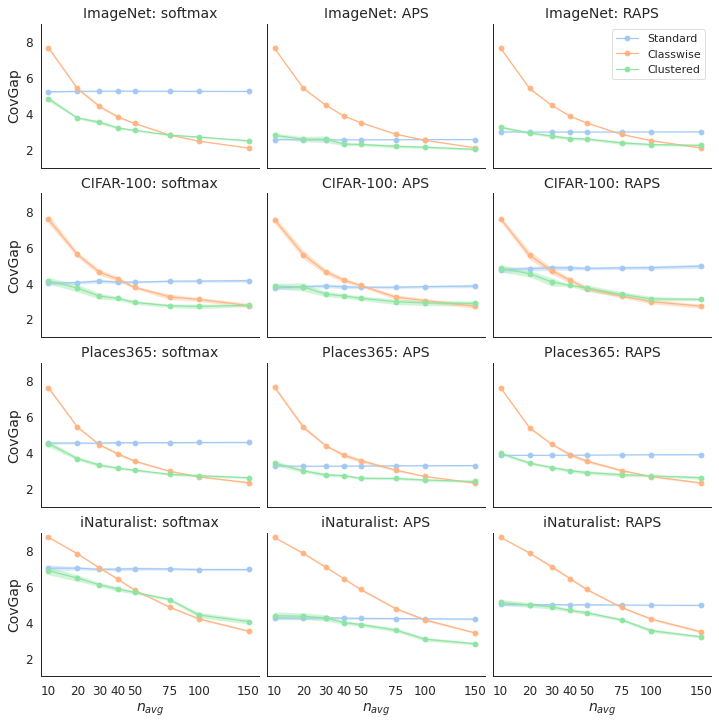

ImageNet, softmax (random calibration set)
ImageNet, APS (random calibration set)
ImageNet, RAPS (random calibration set)
CIFAR-100, softmax (random calibration set)
CIFAR-100, APS (random calibration set)
CIFAR-100, RAPS (random calibration set)
Places365, softmax (random calibration set)
Places365, APS (random calibration set)
Places365, RAPS (random calibration set)
iNaturalist, softmax (random calibration set)
iNaturalist, APS (random calibration set)
iNaturalist, RAPS (random calibration set)
Saved figure to /home/tding/code/class-conditional-conformal/figs/alldatasets_randomcalset_avg_set_size_height12.pdf


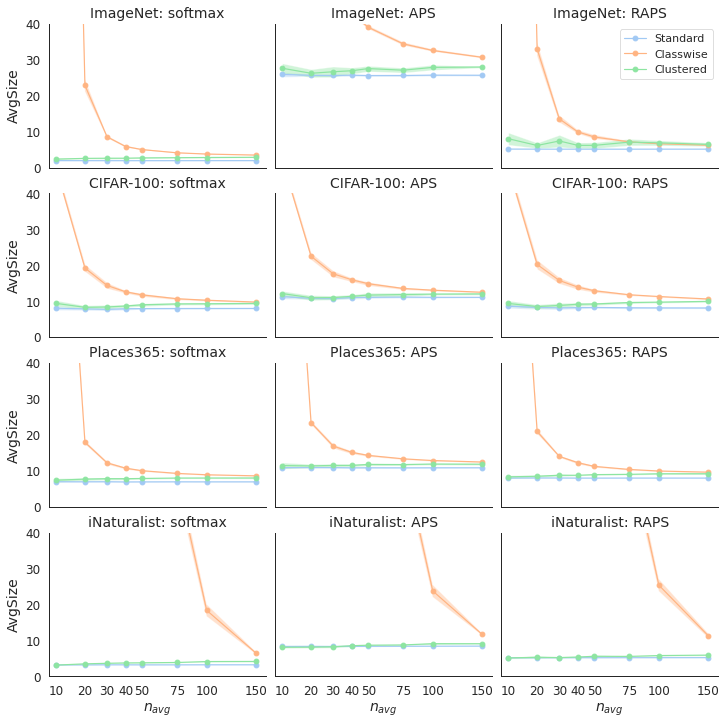

ImageNet, softmax (random calibration set)
ImageNet, APS (random calibration set)
ImageNet, RAPS (random calibration set)
CIFAR-100, softmax (random calibration set)
CIFAR-100, APS (random calibration set)
CIFAR-100, RAPS (random calibration set)
Places365, softmax (random calibration set)
Places365, APS (random calibration set)
Places365, RAPS (random calibration set)
iNaturalist, softmax (random calibration set)
iNaturalist, APS (random calibration set)
iNaturalist, RAPS (random calibration set)
Saved figure to /home/tding/code/class-conditional-conformal/figs/alldatasets_randomcalset_very_undercovered_height12.pdf


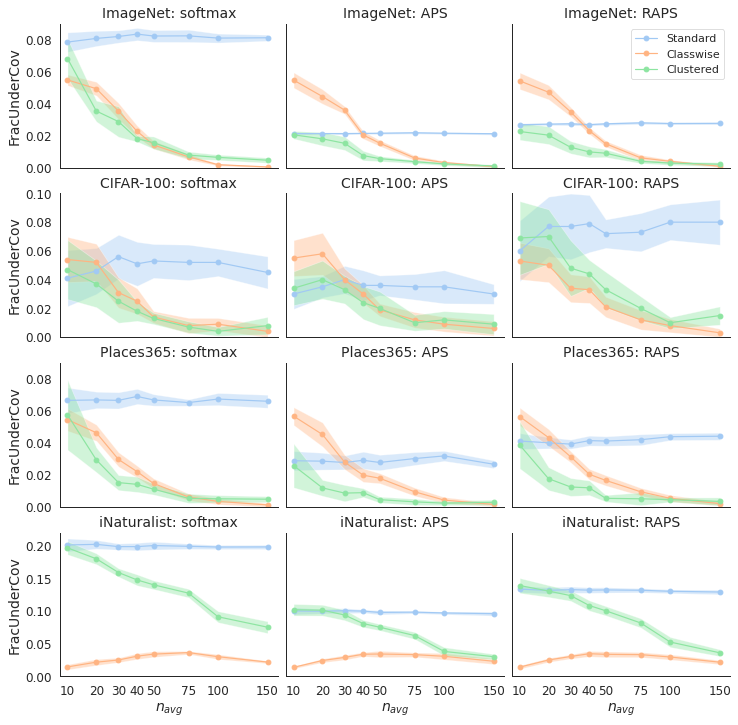

In [13]:
FONT_SIZE = 14
fig_height = 12

# metric_list = ['avg_set_size', 'very_undercovered']
metric_list = ['class_cov_gap', 'avg_set_size', 'very_undercovered']
fig_folder = '/home/tding/code/class-conditional-conformal/figs/'

cal_sampling = 'random'
dataset_list = ['imagenet', 'cifar-100', 'places365', 'inaturalist']
score_function_list = ['softmax','APS', 'RAPS']
method_list = ['standard', 'classwise', 'cluster_random']

nrows = len(dataset_list)
ncols = len(score_function_list)



for metric in metric_list:
    
    fig, axs = plt.subplots(nrows,ncols, 
                gridspec_kw={'wspace':0.04, # Horizontal space between subplots
                             'hspace': 0.18}, # Vertical space between subplots
                figsize=(12, fig_height)) # Prev: (12,9)

    for i, dataset in enumerate(dataset_list):    

        for j, score_function in enumerate(score_function_list):

            ax = axs[i][j]

            aggregated_results = get_metric_df(dataset, cal_sampling, metric, score_function, 
                                               method_list=method_list, print_folder=False)

            # Plot
            make_line_plot(aggregated_results, ax, method_list=method_list)
            ax.set_title(f'{dataset_to_name[dataset]}: {score_function}', 
                         fontsize=FONT_SIZE)
#                          pad=-3) # Shift plot title down


            # Remove x-ticks except for bottom plots
            if i < nrows - 1:
                ax.set_xticks([])
                ax.set_xlabel('.', fontsize=1) # hacky fix

            # Remove y-ticks and label except for left-most plots
            if j > 0:
                ax.set_yticks([])


            # Set y-label
            if j == 0:
                ax.set_ylabel(metric_to_name[metric], fontsize=FONT_SIZE)
                
            # Apply row-by-row adjustments
            if metric == 'avg_set_size':
                ax.set_ylim(0,40)
            elif metric == 'very_undercovered':
                if dataset == 'imagenet' or dataset == 'places365':
                    ax.set_ylim(0,.09)
                if dataset == 'cifar-100':
                    ax.set_ylim(0,.10)
                if dataset == 'inaturalist':
                    ax.set_ylim(0,.22)
                    
            # For AvgSize
#             if metric == 'avg_set_size':
#                 ax.set_yscale('squareroot') # Use square-root y-axis


    #         axs[0].set_ylabel(metric_to_name[metric], fontsize=FONT_SIZE)
    axs[0, ncols-1].legend(fontsize=FONT_SIZE-3) # Only show legend on right-most plot

    save_to = os.path.join(fig_folder, f'alldatasets_{cal_sampling}calset_{metric}_height{fig_height}.pdf')
    plt.savefig(save_to, bbox_inches='tight')
    print(f'Saved figure to {save_to}')

    plt.show()

# 4x3 plots for randomized variants

In [14]:
# randomized_method_to_name = {'exact_coverage_standard': 'Randomized Standard',
#                               'exact_coverage_classwise': 'Randomized Classwise',
#                               'exact_coverage_cluster': 'Randomized Clustered',
#                              'classwise': 'Classwise'} # For comparison purposes
# randomized_method_list = randomized_method_to_name.keys()

ImageNet, softmax (random calibration set)
ImageNet, APS (random calibration set)
ImageNet, RAPS (random calibration set)
CIFAR-100, softmax (random calibration set)
CIFAR-100, APS (random calibration set)
CIFAR-100, RAPS (random calibration set)
Places365, softmax (random calibration set)
Places365, APS (random calibration set)
Places365, RAPS (random calibration set)
iNaturalist, softmax (random calibration set)
iNaturalist, APS (random calibration set)
iNaturalist, RAPS (random calibration set)
Saved figure to /home/tding/code/class-conditional-conformal/figs/randomized_alldatasets_randomcalset_class_cov_gap_height12.pdf


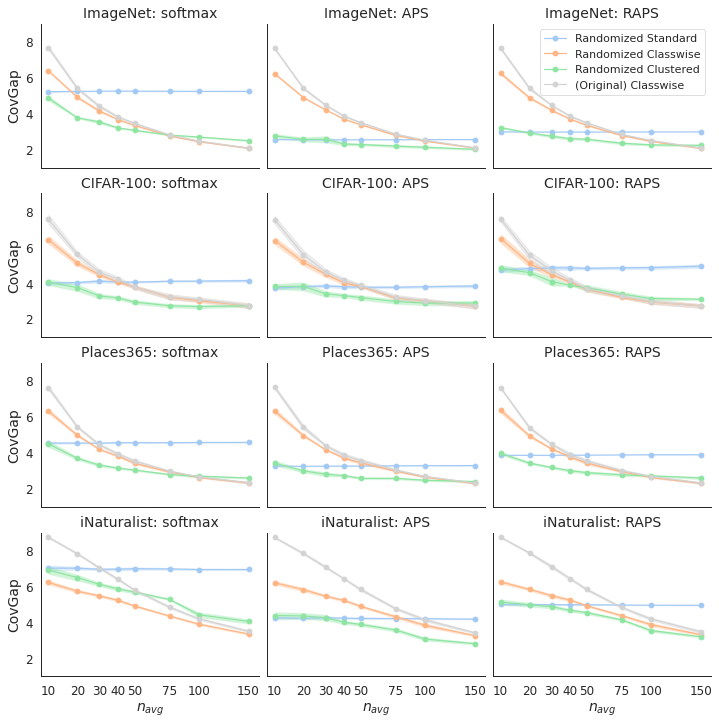

ImageNet, softmax (random calibration set)
ImageNet, APS (random calibration set)
ImageNet, RAPS (random calibration set)
CIFAR-100, softmax (random calibration set)
CIFAR-100, APS (random calibration set)
CIFAR-100, RAPS (random calibration set)
Places365, softmax (random calibration set)
Places365, APS (random calibration set)
Places365, RAPS (random calibration set)
iNaturalist, softmax (random calibration set)
iNaturalist, APS (random calibration set)
iNaturalist, RAPS (random calibration set)
Saved figure to /home/tding/code/class-conditional-conformal/figs/randomized_alldatasets_randomcalset_avg_set_size_height12.pdf


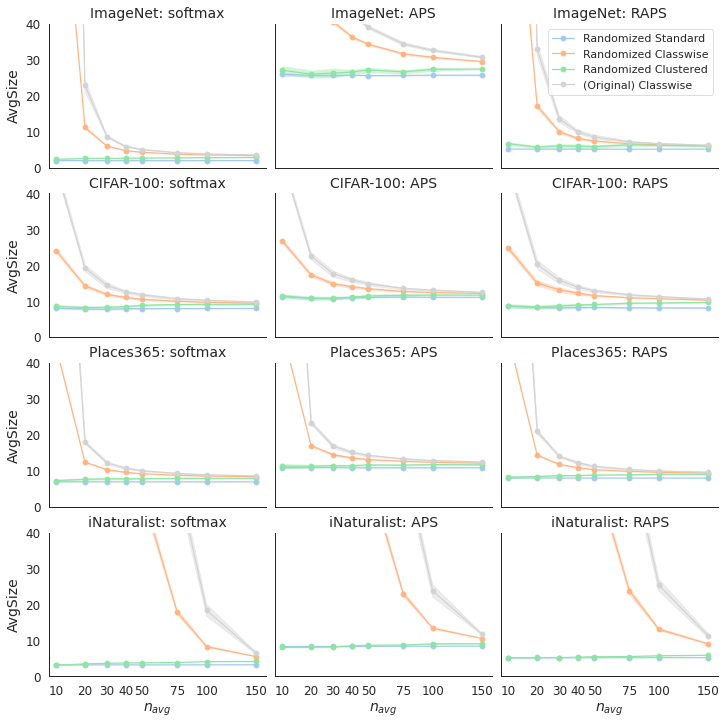

ImageNet, softmax (random calibration set)
ImageNet, APS (random calibration set)
ImageNet, RAPS (random calibration set)
CIFAR-100, softmax (random calibration set)
CIFAR-100, APS (random calibration set)
CIFAR-100, RAPS (random calibration set)
Places365, softmax (random calibration set)
Places365, APS (random calibration set)
Places365, RAPS (random calibration set)
iNaturalist, softmax (random calibration set)
iNaturalist, APS (random calibration set)
iNaturalist, RAPS (random calibration set)
Saved figure to /home/tding/code/class-conditional-conformal/figs/randomized_alldatasets_randomcalset_very_undercovered_height12.pdf


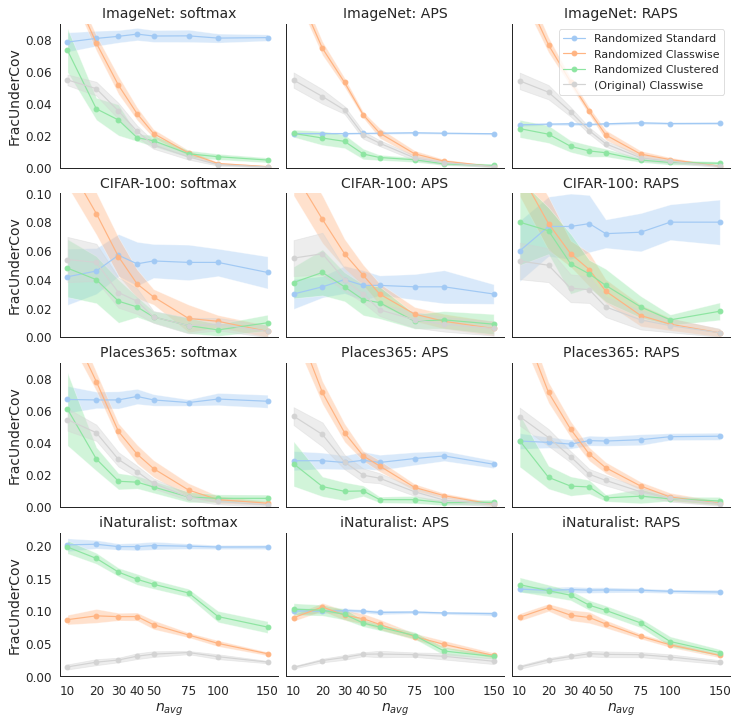

In [15]:
FONT_SIZE = 14
fig_height = 12

# metric_list = ['avg_set_size', 'very_undercovered']
metric_list = ['class_cov_gap', 'avg_set_size', 'very_undercovered']
fig_folder = '/home/tding/code/class-conditional-conformal/figs/'

cal_sampling = 'random'
dataset_list = ['imagenet', 'cifar-100', 'places365', 'inaturalist']
score_function_list = ['softmax','APS', 'RAPS']
method_list = ['exact_coverage_standard', 'exact_coverage_classwise', 'exact_coverage_cluster', 'classwise']

nrows = len(dataset_list)
ncols = len(score_function_list)



for metric in metric_list:
    
    fig, axs = plt.subplots(nrows,ncols, 
                gridspec_kw={'wspace':0.04, # Horizontal space between subplots
                             'hspace': 0.18}, # Vertical space between subplots
                figsize=(12, fig_height)) # Prev: (12,9)

    for i, dataset in enumerate(dataset_list):    

        for j, score_function in enumerate(score_function_list):

            ax = axs[i][j]

            aggregated_results = get_metric_df(dataset, cal_sampling, metric, score_function, 
                                               method_list=method_list, print_folder=False)

            # Plot
            make_line_plot(aggregated_results, ax, method_list=method_list, 
                           method_to_name = { 'classwise': '(Original) Classwise',
                                          'exact_coverage_standard': 'Randomized Standard',
                                          'exact_coverage_classwise': 'Randomized Classwise',
                                          'exact_coverage_cluster': 'Randomized Clustered'},
                           specify_color={'classwise': 'lightgrey'})
            ax.set_title(f'{dataset_to_name[dataset]}: {score_function}', 
                         fontsize=FONT_SIZE)
#                          pad=-3) # Shift plot title down


            # Remove x-ticks except for bottom plots
            if i < nrows - 1:
                ax.set_xticks([])
                ax.set_xlabel('.', fontsize=1) # hacky fix

            # Remove y-ticks and label except for left-most plots
            if j > 0:
                ax.set_yticks([])


            # Set y-label
            if j == 0:
                ax.set_ylabel(metric_to_name[metric], fontsize=FONT_SIZE)
                
            # Apply row-by-row adjustments
            if metric == 'avg_set_size':
                ax.set_ylim(0,40)
            elif metric == 'very_undercovered':
                if dataset == 'imagenet' or dataset == 'places365':
                    ax.set_ylim(0,.09)
                if dataset == 'cifar-100':
                    ax.set_ylim(0,.10)
                if dataset == 'inaturalist':
                    ax.set_ylim(0,.22)
                    
            # For AvgSize
#             if metric == 'avg_set_size':
#                 ax.set_yscale('squareroot') # Use square-root y-axis


    #         axs[0].set_ylabel(metric_to_name[metric], fontsize=FONT_SIZE)
    axs[0, ncols-1].legend(fontsize=FONT_SIZE-3) # Only show legend on right-most plot

    save_to = os.path.join(fig_folder, f'randomized_alldatasets_{cal_sampling}calset_{metric}_height{fig_height}.pdf')
    plt.savefig(save_to, bbox_inches='tight')
    print(f'Saved figure to {save_to}')

    plt.show()